## PYTHON SIMULATION FOR ECGSYN.DAT

1. Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

2. Loading the ecgsyn.dat

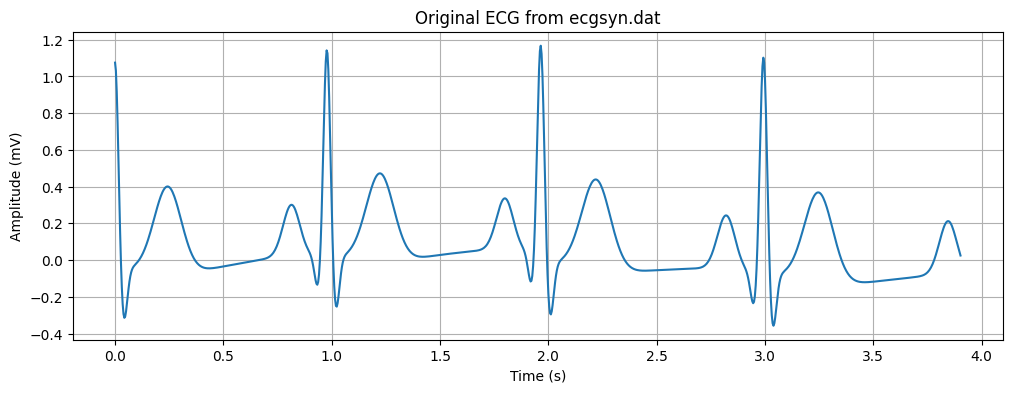

In [4]:
# Load ecgsyn.dat
ecgsyn_data = np.loadtxt("ecgsyn.dat")
t = ecgsyn_data[:, 0]
ecg_real = ecgsyn_data[:, 1]
fs = int(1 / (t[1] - t[0]))

plt.figure(figsize=(12, 4))
plt.plot(t[:1000], ecg_real[:1000])
plt.title("Original ECG from ecgsyn.dat")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()


3. Add Noise (Motion Artifact, Powerline, 1/f Flicker Noise)

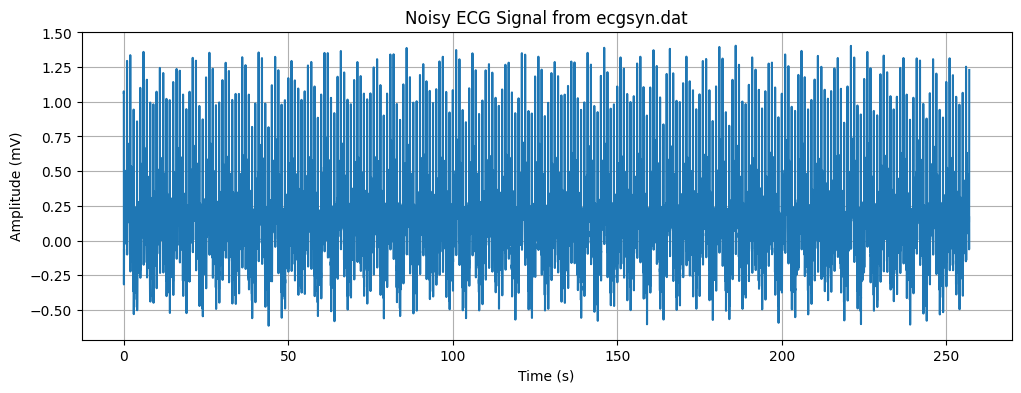

In [5]:
# Load ECG signal
t = ecgsyn_data[:, 0]
ecg_clean = ecgsyn_data[:, 1]
fs = int(1 / (t[1] - t[0]))  # Sampling frequency

# Motion artifact (baseline wander)
motion_artifact = 0.2 * np.sin(2 * np.pi * 0.2 * t)

# Powerline noise (50Hz)
powerline_noise = 0.05 * np.sin(2 * np.pi * 50 * t)

# 1/f flicker noise (Pink noise approximation)
def flicker_noise(length, beta=1):
    freqs = np.fft.rfftfreq(length, d=1/fs)
    amplitude = 1 / (freqs + 1e-4)**(beta / 2.0)
    phases = np.random.uniform(0, 2 * np.pi, len(freqs))
    noise = amplitude * (np.cos(phases) + 1j * np.sin(phases))
    time_domain_noise = np.fft.irfft(noise)
    return time_domain_noise / np.max(np.abs(time_domain_noise)) * 0.05

flicker = flicker_noise(len(t))

# Composite noisy ECG
ecg_noisy = ecg_clean + motion_artifact + powerline_noise + flicker

# Plot noisy ECG
plt.figure(figsize=(12, 4))
plt.plot(t, ecg_noisy)
plt.title('Noisy ECG Signal from ecgsyn.dat')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.grid()
plt.show()


4. 4. Bandpass Filtering (0.5 Hz – 155 Hz)

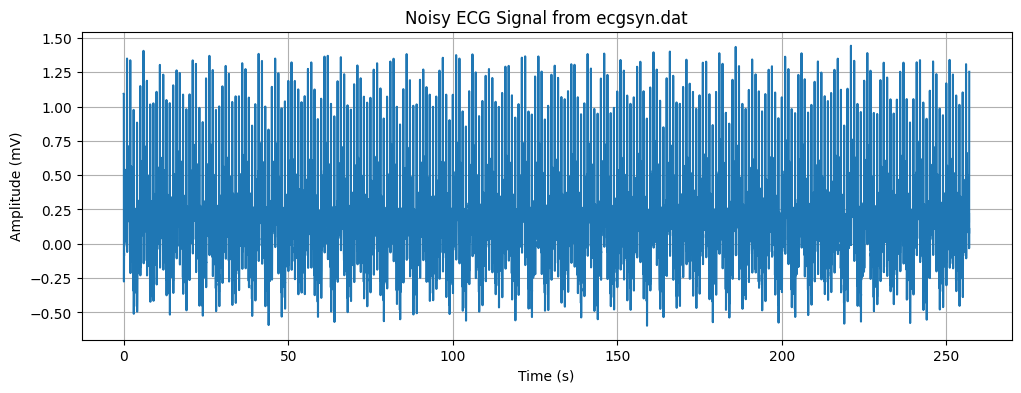

In [7]:
# Load ECG signal
t = ecgsyn_data[:, 0]
ecg_clean = ecgsyn_data[:, 1]
fs = int(1 / (t[1] - t[0]))  # Sampling frequency

# Motion artifact (baseline wander)
motion_artifact = 0.2 * np.sin(2 * np.pi * 0.2 * t)

# Powerline noise (50Hz)
powerline_noise = 0.05 * np.sin(2 * np.pi * 50 * t)

# 1/f flicker noise (Pink noise approximation)
def flicker_noise(length, beta=1):
    freqs = np.fft.rfftfreq(length, d=1/fs)
    amplitude = 1 / (freqs + 1e-4)**(beta / 2.0)
    phases = np.random.uniform(0, 2 * np.pi, len(freqs))
    noise = amplitude * (np.cos(phases) + 1j * np.sin(phases))
    time_domain_noise = np.fft.irfft(noise)
    return time_domain_noise / np.max(np.abs(time_domain_noise)) * 0.05

flicker = flicker_noise(len(t))

# Composite noisy ECG
ecg_noisy = ecg_clean + motion_artifact + powerline_noise + flicker

# Plot noisy ECG
plt.figure(figsize=(12, 4))
plt.plot(t, ecg_noisy)
plt.title('Noisy ECG Signal from ecgsyn.dat')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.grid()
plt.show()


5. LNA SIMULATION

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# Load ECG data
ecgsyn_data = np.loadtxt("ecgsyn.dat")
t = ecgsyn_data[:, 0]
ecg_real = ecgsyn_data[:, 1]
fs = int(1 / (t[1] - t[0]))

# Add noise
motion_artifact = 0.2 * np.sin(2 * np.pi * 0.2 * t)
powerline_noise = 0.05 * np.sin(2 * np.pi * 50 * t)

def flicker_noise(length, beta=1):
    freqs = np.fft.rfftfreq(length, d=1/fs)
    amplitude = 1 / (freqs + 1e-4)**(beta / 2.0)
    phases = np.random.uniform(0, 2 * np.pi, len(freqs))
    noise = amplitude * (np.cos(phases) + 1j * np.sin(phases))
    return np.fft.irfft(noise)[:length] * 0.05

flicker = flicker_noise(len(t))

# Composite noisy ECG
ecg_noisy = ecg_real + motion_artifact + powerline_noise + flicker

# Bandpass filter
def bandpass_filter(data, lowcut=0.5, highcut=155.0, fs=500, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

ecg_filtered = bandpass_filter(ecg_noisy)

# Simulate LNA Amplifier with 60 dB Gain
gain_db = 60
gain_linear = 10 ** (gain_db / 20)
ecg_amplified = ecg_filtered * gain_linear

# Display the filtered and amplified ECG as a DataFrame (first 1000 samples)
df_amplified = pd.DataFrame({
    "Time (s)": t[:1000],
    "Filtered ECG (mV)": ecg_filtered[:1000],
    "Amplified ECG (mV)": ecg_amplified[:1000]
})
print(df_amplified.head())


   Time (s)  Filtered ECG (mV)  Amplified ECG (mV)
0  0.000000          -0.102738         -102.738460
1  0.003906          -0.097823          -97.823499
2  0.007812          -0.218155         -218.155291
3  0.011719          -0.442244         -442.243958
4  0.015625          -0.660241         -660.240546


5.1 📊Time-Domain Plot of Filtered vs Amplified ECG

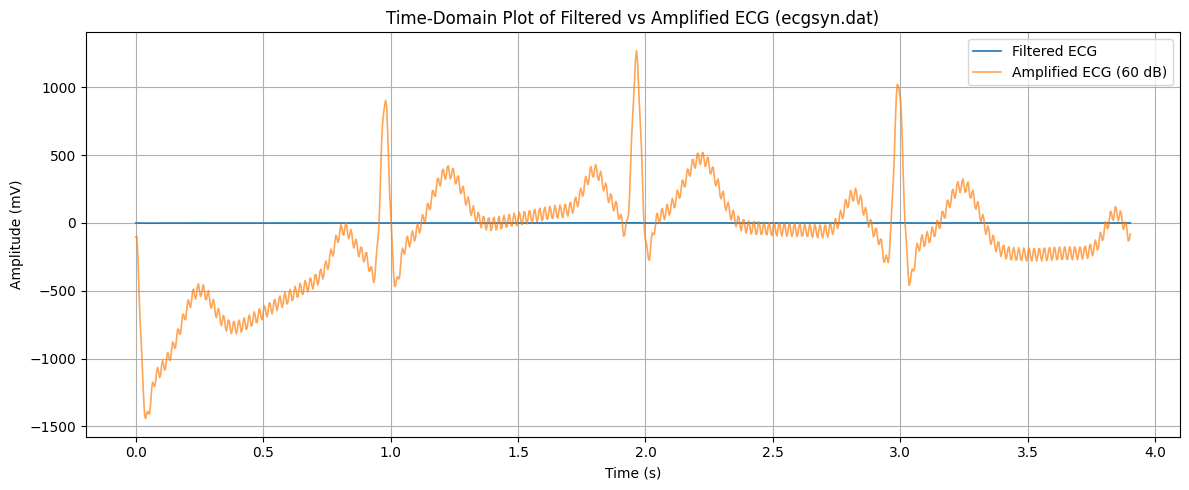

In [15]:
# 5.1 📊 Time-Domain Plot of Filtered vs Amplified ECG (ecgsyn.dat)

# Make sure you already have `t`, `ecg_filtered`, and `ecg_amplified` defined from previous steps

plt.figure(figsize=(12, 5))
plt.plot(t[:1000], ecg_filtered[:1000], label="Filtered ECG", linewidth=1.2)
plt.plot(t[:1000], ecg_amplified[:1000], label="Amplified ECG (60 dB)", alpha=0.7, linewidth=1.2)
plt.title("Time-Domain Plot of Filtered vs Amplified ECG (ecgsyn.dat)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


5.2 Generating ECG Signals for the LNA

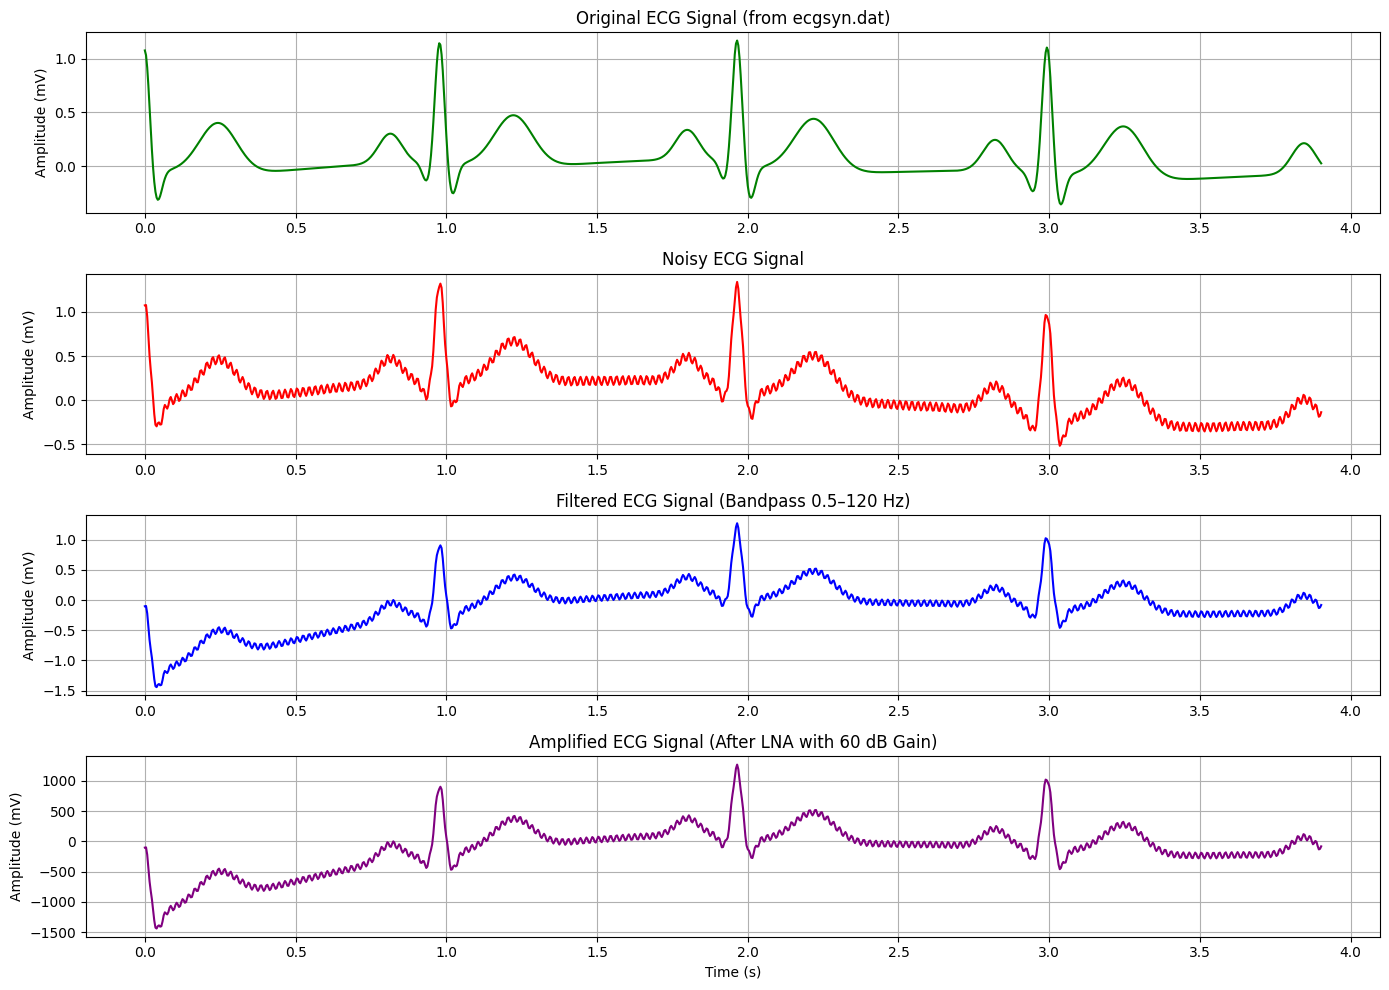

In [16]:
# Plot full ECG processing pipeline
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(t[:1000], ecg_real[:1000], label='Original ECG (ecgsyn)', color='green')
plt.title('Original ECG Signal (from ecgsyn.dat)')
plt.ylabel('Amplitude (mV)')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t[:1000], ecg_noisy[:1000], label='Noisy ECG', color='red')
plt.title('Noisy ECG Signal')
plt.ylabel('Amplitude (mV)')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t[:1000], ecg_filtered[:1000], label='Filtered ECG', color='blue')
plt.title('Filtered ECG Signal (Bandpass 0.5–120 Hz)')
plt.ylabel('Amplitude (mV)')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t[:1000], ecg_amplified[:1000], label='Amplified ECG (60 dB)', color='purple')
plt.title('Amplified ECG Signal (After LNA with 60 dB Gain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.grid(True)

plt.tight_layout()
plt.show()

6. Peak Detection with Dynamic Threshold

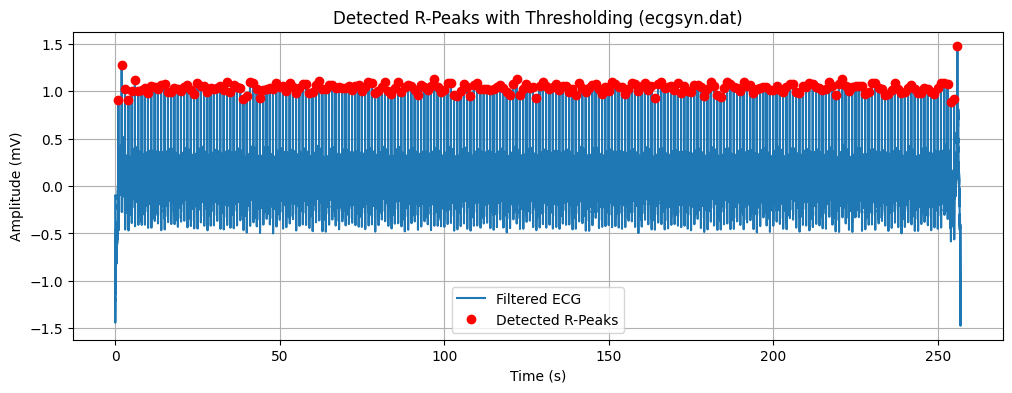

In [17]:

# Dynamic threshold (percentage of max amplitude from ecgsyn ECG)
threshold = 0.6 * np.max(ecg_filtered)

# Find peaks above threshold and spaced at least 0.6s apart
peaks, _ = signal.find_peaks(ecg_filtered, height=threshold, distance=0.6 * fs)

# Plot filtered ECG and detected peaks
plt.figure(figsize=(12, 4))
plt.plot(t, ecg_filtered, label='Filtered ECG')
plt.plot(t[peaks], ecg_filtered[peaks], 'ro', label='Detected R-Peaks')
plt.title('Detected R-Peaks with Thresholding (ecgsyn.dat)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid()
plt.show()

7. Evaluate Heart Rate (BPM)

Heart Rates (BPM): [60.95238095 58.62598284 58.18181818 61.19520352 60.95238095 57.96227815
 59.76649231 62.43905688 61.93548387 59.07692308 59.07692308 61.43996854
 59.76655185 57.52813126 58.18181818 61.68669942 60.47247142 60.
 61.19520352 62.69389393 60.71141638 58.18181818 58.85058914 59.53491326
 58.62592556 59.07692308 61.19526593 61.43996854 60.95238095 60.47241047
 60.95244287 59.76649231 57.96227815 59.76655185 60.235279   59.76655185
 59.30500465 61.68676284 61.43996854 58.85058914 58.85058914 60.235279
 60.47247142 59.07686491 59.76655185 61.93548387 61.19526593 58.85053142
 59.07692308 60.71147781 59.30500465 58.62598284 60.         62.1862187
 60.47241047 59.53491326 60.235279   60.235279   59.53491326 58.85058914
 60.235279   61.19520352 60.         60.         60.235279   60.
 58.62598284 59.07692308 60.71147781 60.235279   60.235279   60.95238095
 61.19526593 60.235279   59.53485418 58.85058914 59.07692308 59.76655185
 59.30500465 60.         60.95238095 61.19520352 61

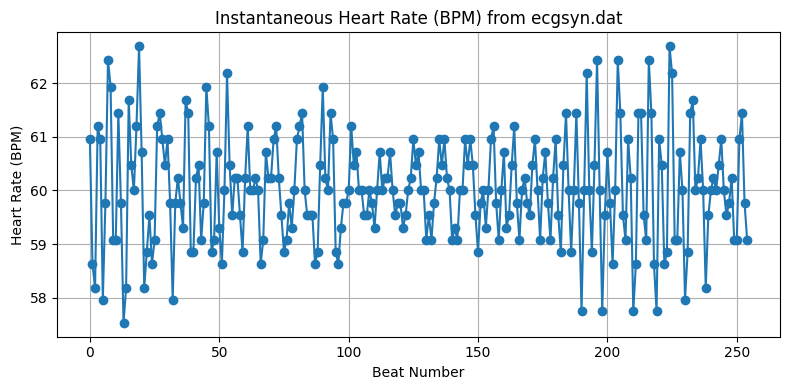

In [18]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# 1. Dynamic threshold for peak detection
threshold = 0.6 * np.max(ecg_filtered)
peaks, _ = signal.find_peaks(ecg_filtered, height=threshold, distance=int(0.6 * fs))

# 2. Compute RR intervals and convert to heart rate (BPM)
rr_intervals = np.diff(t[peaks])  # in seconds
heart_rates = 60 / rr_intervals   # BPM

# 3. Print BPM values
print("Heart Rates (BPM):", heart_rates)

# 4. Plot heart rate over beat number
plt.figure(figsize=(8, 4))
plt.plot(heart_rates, '-o')
plt.title('Instantaneous Heart Rate (BPM) from ecgsyn.dat')
plt.xlabel('Beat Number')
plt.ylabel('Heart Rate (BPM)')
plt.grid(True)
plt.tight_layout()
plt.show()


8. SIMULATION ON SR LATCH AND AND

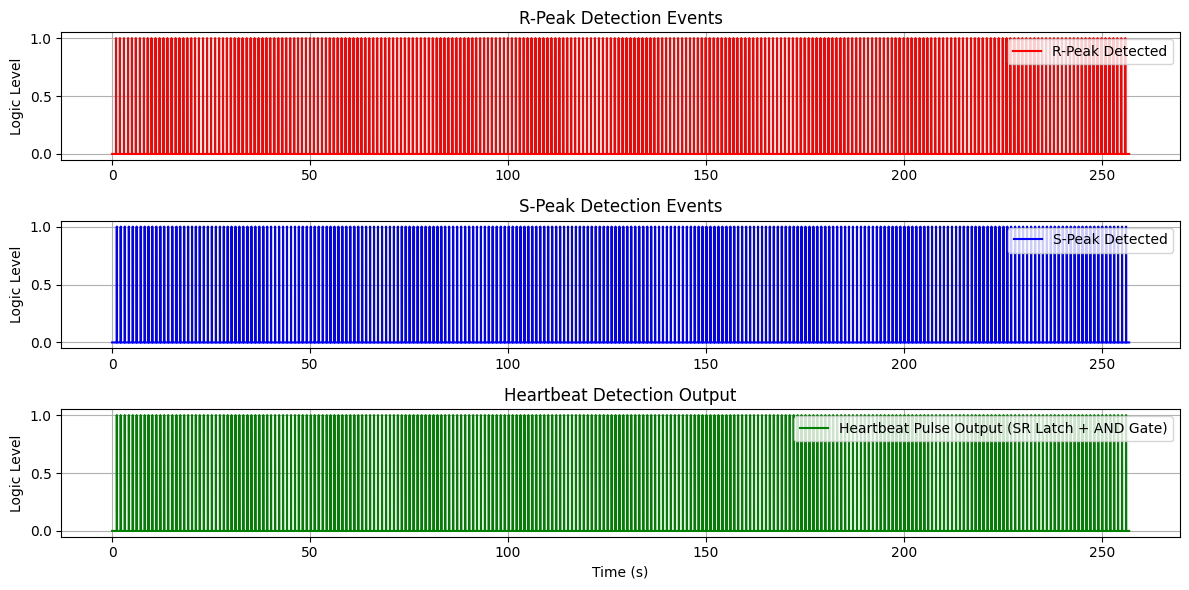

In [19]:
# Use existing sampling rate and time vector from ecgsyn.dat
# fs and t already defined from earlier (fs ≈ 256 Hz)

# Simulate R-peaks (detected peaks from dynamic or adaptive thresholding)
# We'll use actual R-peak indices from earlier peak detection
r_peaks_indices = peaks.tolist()  # from previous signal.find_peaks()

# Simulate S-peaks slightly after R-peaks (~200 ms later)
s_peaks_indices = [i + int(0.2 * fs) for i in r_peaks_indices if i + int(0.2 * fs) < len(t)]

# Binary event signals for logic simulation
r_signal = np.zeros_like(t)
s_signal = np.zeros_like(t)

# Mark events
r_signal[r_peaks_indices] = 1
s_signal[s_peaks_indices] = 1

# SR Latch + AND Gate Simulation
sr_latch_state = 0
heartbeat_output = np.zeros_like(t)

for i in range(len(t)):
    if r_signal[i] == 1:
        sr_latch_state = 1  # Set latch
    if s_signal[i] == 1 and sr_latch_state == 1:
        heartbeat_output[i] = 1  # Confirmed beat
        sr_latch_state = 0       # Reset latch

# Plot the simulation logic
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(t, r_signal, 'r', label='R-Peak Detected')
plt.legend()
plt.title('R-Peak Detection Events')
plt.ylabel('Logic Level')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, s_signal, 'b', label='S-Peak Detected')
plt.legend()
plt.title('S-Peak Detection Events')
plt.ylabel('Logic Level')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, heartbeat_output, 'g', label='Heartbeat Pulse Output (SR Latch + AND Gate)')
plt.legend()
plt.title('Heartbeat Detection Output')
plt.xlabel('Time (s)')
plt.ylabel('Logic Level')
plt.grid(True)

plt.tight_layout()
plt.show()

## ✅ Next Steps (Optional Enhancements):

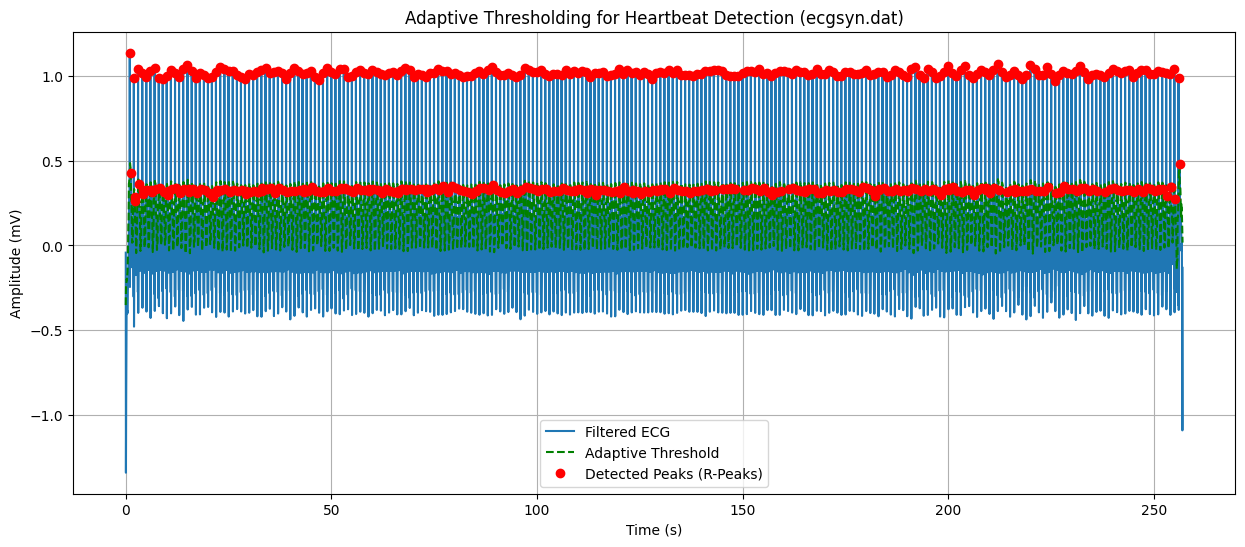

Heart Rates (BPM): [ 243.80927613   80.8420508   232.72772408 3071.88203973   80.
  236.30792498   77.96956848  243.80927613 3072.0393221    83.93439688]


In [20]:
# Load ECG signal from ecgsyn.dat
ecgsyn_data = np.loadtxt("ecgsyn.dat")
t = ecgsyn_data[:, 0]
ecg_real = ecgsyn_data[:, 1]
fs = int(1 / (t[1] - t[0]))  # Sampling frequency from data

# Add noise
motion_artifact = 0.2 * np.sin(2 * np.pi * 0.2 * t)
powerline_noise = 0.05 * np.sin(2 * np.pi * 50 * t)
def flicker_noise(length, beta=1):
    freqs = np.fft.rfftfreq(length, d=1/fs)
    amplitude = 1 / (freqs + 1e-4)**(beta / 2.0)
    phases = np.random.uniform(0, 2 * np.pi, len(freqs))
    noise = amplitude * (np.cos(phases) + 1j * np.sin(phases))
    return np.fft.irfft(noise)[:length] / np.max(np.abs(np.fft.irfft(noise))) * 0.05
flicker = flicker_noise(len(t))
ecg_noisy = ecg_real + motion_artifact + powerline_noise + flicker

# Bandpass filter
def bandpass_filter(sig, lowcut=0.5, highcut=40.0, fs=fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, sig)
ecg_filtered = bandpass_filter(ecg_noisy)

# Adaptive thresholding
window_size = int(0.5 * fs)
k = 1.0
adaptive_threshold = np.zeros_like(ecg_filtered)
for i in range(len(ecg_filtered)):
    start = max(0, i - window_size // 2)
    end = min(len(ecg_filtered), i + window_size // 2)
    local_window = ecg_filtered[start:end]
    local_mean = np.mean(local_window)
    local_std = np.std(local_window)
    adaptive_threshold[i] = local_mean + k * local_std

# Peak detection
peaks = []
for i in range(1, len(ecg_filtered) - 1):
    if ecg_filtered[i] > adaptive_threshold[i]:
        if ecg_filtered[i] > ecg_filtered[i - 1] and ecg_filtered[i] > ecg_filtered[i + 1]:
            peaks.append(i)
peaks = np.array(peaks)

# Plot result
plt.figure(figsize=(15, 6))
plt.plot(t, ecg_filtered, label='Filtered ECG')
plt.plot(t, adaptive_threshold, 'g--', label='Adaptive Threshold')
plt.plot(t[peaks], ecg_filtered[peaks], 'ro', label='Detected Peaks (R-Peaks)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Adaptive Thresholding for Heartbeat Detection (ecgsyn.dat)')
plt.legend()
plt.grid()
plt.show()

# Heart rate calculation
rr_intervals = np.diff(t[peaks])
heart_rates = 60 / rr_intervals
print("Heart Rates (BPM):", heart_rates[:10])  # show first 10